In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from tia.bbg import LocalTerminal
from pandas.tseries.offsets import *
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import sklearn.mixture as mix
import statsmodels.api as sm
import networkx as nx
from pprint import pprint 

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns


In [2]:
# Getting BBG data and cleaning
StartDate = '1995-12-30'
EndDate = (dt.datetime.today()-BDay(1)).strftime("%m/%d/%Y")

Dates = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="D"),columns=['Date'])
Dates = Dates.set_index('Date',drop=True)
Dates.index.name = None

Month = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="M"),columns=['Date'])
Month = Month.set_index('Date',drop=True)
Month.index.name = None

Quarter = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="Q"),columns=['Date'])
Quarter = Quarter.set_index('Date',drop=True)
Quarter.index.name = None

In [3]:
# Take EPI data from excel

# Read EPI
AusEPIEx = pd.ExcelFile('M:\ANGUS\Working\MacroRegime\MacroRegEPI.xlsx').parse('MacroRegEPI')
AusEPIEx.index = AusEPIEx['Date']
AusEPIEx = AusEPIEx.drop(columns = ['Date'])
AusEPIEx = AusEPIEx.fillna(method='ffill')
AusEPIEx = Dates.merge(AusEPIEx,right_index=True,left_index=True,how='left')
AusEPIEx = AusEPIEx.fillna(method='ffill')
AusEPIEx = Month.merge(AusEPIEx,right_index=True,left_index=True,how='left')

In [4]:
AusEPIEx.tail()

EpiM_Headline_AU  EpiM_Business_AU  EpiM_Consumer_AU  \
2019-08-31         -1.201616         -0.810514         -1.547828   
2019-09-30         -1.122207         -0.709136         -0.904735   
2019-10-31         -1.152160         -0.680101         -0.742778   
2019-11-30         -1.093602         -0.386141         -0.380259   
2019-12-31         -0.955334         -0.722078         -0.376885   

            EpiM_Employment_AU  EpiM_Growth_AU  EpiM_Inflation_AU  \
2019-08-31           -0.238016       -1.173196          -0.109109   
2019-09-30           -0.289336       -1.264090          -0.267672   
2019-10-31           -0.422667       -1.250853          -0.378492   
2019-11-30           -0.878802       -1.183764          -0.398445   
2019-12-31           -0.134679       -1.090942          -0.406488   

            EpiM_Headline_NZ  EpiM_Business_NZ  EpiM_Consumer_NZ  \
2019-08-31          0.130303         -1.020304         -0.354152   
2019-09-30         -0.030897         -1.206799         -0.276482   
2019-10-31         -0.095115         -1.216050         -0.208466   
2019-11-30          0.181349         -0.630998          0.170338   
2019-12-31          0.663546         -0.369224          0.546356   

            EpiM_Employment_NZ  ...  EpiM_Consumer_UK  EpiM_Employment_UK  \
2019-08-31            1.438950  ...          0.072789            0.177752   
2019-09-30            1.428814  ...          0.009009            0.166787   
2019-10-31            1.398130  ...          0.066458            0.229262   
2019-11-30            1.078143  ...         -0.075605            0.062089   
2019-12-31            1.072784  ...         -0.109736            0.071851   

            EpiM_Growth_UK  EpiM_Inflation_UK  EpiM_Headline_Global  \
2019-08-31       -0.536816          -0.801183             -0.469911   
2019-09-30       -0.535227          -0.380680             -0.325728   
2019-10-31       -0.531307          -0.945866             -0.447875   
2019-11-30       -0.077558          -1.271533             -0.525725   
2019-12-31        0.009556          -0.794296             -0.520160   

            EpiM_Business_Global  EpiM_Consumer_Global  \
2019-08-31             -0.711712             -0.442848   
2019-09-30             -0.614337             -0.283837   
2019-10-31             -0.703352             -0.306907   
2019-11-30             -0.716446             -0.368442   
2019-12-31             -1.026876             -0.476515   

            EpiM_Employment_Global  EpiM_Growth_Global  EpiM_Inflation_Global  
2019-08-31                0.199673           -0.326406              -0.337889  
2019-09-30                0.404698           -0.305914              -0.347894  
2019-10-31                0.302243           -0.377753              -0.475776  
2019-11-30                0.171067           -0.458164              -0.393423  
2019-12-31                0.304541           -0.554854               0.096949  

[5 rows x 42 columns]

In [5]:
# Take Bloomberg data from excel

# Read Bloomberg Data
Ecodata = pd.ExcelFile('\\capricorn\AusFI\ANGUS\Working\MacroRegime\MacroRegBBGUpdate.xlsx').parse('Month')
Ecodata = Ecodata.iloc[2:]
Ecodata.index = Ecodata['NAME']
Ecodata = Ecodata.drop(columns = ['NAME'])
Ecodata = Ecodata.fillna(method='ffill')
Ecodata = Dates.merge(Ecodata,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.fillna(method='ffill')
Ecodata = Month.merge(Ecodata,right_index=True,left_index=True,how='left')


# Read in half-yearly bak NIMs
BankData1 = pd.ExcelFile('\\capricorn\AusFI\ANGUS\Working\MacroRegime\MacroRegBBGUpdate.xlsx').parse('Quarter')
BankData1 = BankData1.iloc[1:]
BankData1.index = BankData1['Unnamed: 0']
BankData1 = BankData1.drop(columns = ['Unnamed: 0'])
BankData1 = BankData1.fillna(method='ffill')
BankData1 = Dates.merge(BankData1,right_index=True,left_index=True,how='left')
BankData1 = BankData1.fillna(method='ffill')
BankData1 = Month.merge(BankData1,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.merge(BankData1,right_index=True,left_index=True,how='left')

#Read in quarterly Bank NIMs
BankData2 = pd.ExcelFile('\\capricorn\AusFI\ANGUS\Working\MacroRegime\MacroRegBBGUpdate.xlsx').parse('BiAnn')
BankData2 = BankData2.iloc[1:]
BankData2.index = BankData2['Unnamed: 0']
BankData2 = BankData2.drop(columns = ['Unnamed: 0'])
BankData2 = BankData2.fillna(method='ffill')
BankData2 = Dates.merge(BankData2,right_index=True,left_index=True,how='left')
BankData2 = BankData2.fillna(method='ffill')
BankData2 = Month.merge(BankData2,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.merge(BankData2,right_index=True,left_index=True,how='left')

In [6]:
# Put the codes in 

NamesIdx = ['EPI ex inflation M','EPI ex inflation L','EPI Synchronised Sectors or Regions M','EPI Synchronised Sectors or Regions L',
'Earnings Growth M','Earnings Growth L','Investment/Capex M','Investment/Capex L','Credit Growth M',
'Credit Growth L','Inventory Cycle M',
'Inventory Cycle L','Global Trade M','Global Trade L','Fiscal Impulse M','Fiscal Impulse L',
'EPI Inflation M','EPI Inflation L','Wage Inflation M','Wage Inflation L','Core (Persistence/Breadth) M',
'Core (Persistence/Breadth) L','OECD Output Gap M','OECD Output Gap L','Employment EPI M',
'Employment EPI L','Unemployment level vs NAIRU M','Unemployment level vs NAIRU L',
'Capacity Utilisation M','Capacity Utilisation L','Property (1y momentum) M','Property (level) L',
'Equities M','Equities L','Household Leverage M','Household Leverage L','Corporate Leverage M',
'Corporate Leverage L','Government Leverage M','Government Leverage L',
'Public Sector Liquidity ==> Reserves, Central Bank BS M','Public Sector Liquidity ==> Reserves, Central Bank BS L',
'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M',
'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L',
'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M',
'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L',
'Real Policy Rate vs real neutral rate M','Real Policy Rate vs real neutral rate L','Real Long End Yields M',
'Real Long End Yield L','Real Ccy vs ToT M','Real Ccy vs ToT L','Financial Sector Health M',
'Financial Sector Health L','Credit Spreads M','Credit Spreads L']

CodesIdx = ['AS51 Index','AUCEYOY Index','OZCACRED Index','NABSCAPS Index','AUNAINV Index','AUITGSB Index','AUITEXP Index',
'AUITIMP Index','EHBBAUY Index','AUNASFCE Index','AUNATEXP Index','AUNATGG Index','AUWSTTSA Index','RBCPWM%Y Index',
'OEEOAUUG Index','AULFUNEM Index','NABSCUTI Index','RPAUMED Index','CPNFAUHG Index',
'CPNFAUA3 Index','AUNATGI Index','CPNFAUNG Index','CPNFAUOG Index',
'FARBCRED Index',
'EBBSTOTA Index',
'EURUSD Curncy',
'BJACTOTL Index',
'JPYUSD Curncy',
'CNBMTTAS Index',
'CNYUSD Curncy',
'OZCABASY Index','OZCABRDY Index','AUM3Y Index',
'AUM1Y Index','USCABAL Index','ECOCEAS Index','ECOCJPN Index','ECOCCNN Index','RBACOR Index','ADGGBE05 Index',
'AUCPIYOY Index',
'USNREUAR Index',
'USNRUS Index',           
'GACGB10 Index','193.028 Index','CTOTAUD Index','CBA AU Equity','WBC AU Equity','NAB AU Equity',
'ANZ AU Equity','BAUCOAS Index']



In [7]:
CodesNamesIdx = ['S&P/ASX 200 INDEX','Australia New Capital Expendit','RBA Financial Aggregate Credit',
'National Australia Bank Busine',
'GDP Inventories','Australia Trade Balance Goods',
'Australia Exports Goods & Serv','Australia Imports Goods & Serv','Australia Budget Balance (% GD',
'Australia GDP State & Local Go','Australia GDP Final Consumptio','Australia GDP Public GFCF Gene',
'Australia Wages & Salaries Tot','Australia CPI Measures Weighte',
'OECD Eco Outlook Australia Out','Australia Labor Force Unemploy','National Australia Bank Busine',
'Australia CoreLogic - Median C','BIS Australia Credit to Househ',
'Australia Total Credit to Hous','Australia Household Income Use','BIS Australia Credit to Non Fi',
'BIS Australia Credit to Genera',
 'US Factors Supplying Reserve F',
'ECB Balance Sheet All Assets',
'EUR-USD X-RATE',
'Bank of Japan assets:Total',
'JPY-USD X-RATE',
'China Central Bank Balance She',
'CNY-USD X-RATE',                
'RBA Financial Aggregate Money','RBA Financial Aggregate Broad',
'Australia Money Supply M3 YoY','Australia Money Supply M1 YoY','US Nominal Account Balance In',
'Eurozone Current Account Balan','Japan Current Account Balance','China Current Account Balance',
'RBA Interbank Overnight Cash R','Australia Breakeven 5 Year','Australia CPI All Groups Goods',
'Laubach Williams Natural Rate',
'Laubach Williams Natural Rate',
'Australia Govt Bonds Generic Y','IMF Australia Real Effective E','Citi Terms of Trade Index - Au',
'COMMONWEALTH BANK OF AUSTRAL','WESTPAC BANKING CORP','NATIONAL AUSTRALIA BANK LTD',
'AUST AND NZ BANKING GROUP','Bloomberg Barclays Australian']

In [9]:
#Copies and Adjustments

#Main Code df
RegCode = pd.DataFrame(0,index=Month.index, columns=NamesIdx)
PXLast = pd.DataFrame(0,index=Month.index, columns=NamesIdx)

for i in Ecodata.columns:
    PXLast = PXLast.merge(Ecodata[i],right_index=True,left_index=True,how='left')


#Add in EPI
PXLast['EpiM_Headline_AU'] = AusEPIEx['EpiM_Headline_AU'].copy()
PXLast['EpiM_Business_AU'] = AusEPIEx['EpiM_Business_AU'].copy()
PXLast['EpiM_Consumer_AU'] = AusEPIEx['EpiM_Consumer_AU'].copy()
PXLast['EpiM_Employment_AU'] = AusEPIEx['EpiM_Employment_AU'].copy()
PXLast['EpiM_Growth_AU'] = AusEPIEx['EpiM_Growth_AU'].copy()
PXLast['EpiM_Inflation_AU'] = AusEPIEx['EpiM_Inflation_AU'].copy()



In [10]:
# Start adjusting data series

#YOY%
PXLast['OZCACRED Index'] = (PXLast['OZCACRED Index']/PXLast['OZCACRED Index'].shift(12) -1)
PXLast['AUITEXP Index'] = (PXLast['AUITEXP Index']/PXLast['AUITEXP Index'].shift(12) -1)
PXLast['AUITIMP Index'] = (PXLast['AUITIMP Index']/PXLast['AUITIMP Index'].shift(12) -1)
PXLast['AUNASFCE Index'] = (PXLast['AUNASFCE Index']/PXLast['AUNASFCE Index'].shift(12) -1)
PXLast['AUNATEXP Index'] = (PXLast['AUNATEXP Index']/PXLast['AUNATEXP Index'].shift(12) -1)
PXLast['AUNATGG Index'] = (PXLast['AUNATGG Index']/PXLast['AUNATGG Index'].shift(12) -1)
PXLast['AUWSTTSA Index'] = (PXLast['AUWSTTSA Index']/PXLast['AUWSTTSA Index'].shift(12) -1)

# Unemployment vs NAIRU estimate of 4.5% for Australia
PXLast['AULFUNEM Index'] = (PXLast['AULFUNEM Index'] - 4.5)

# Inverse for unemployment, fiscal and debt, credit spreads
PXLast['AULFUNEM Index'] = -1*PXLast['AULFUNEM Index']
PXLast['EHBBAUY Index'] = -1*PXLast['EHBBAUY Index']
PXLast['CPNFAUHG Index'] = -1*PXLast['CPNFAUHG Index']
PXLast['CPNFAUNG Index'] = -1*PXLast['CPNFAUNG Index']
PXLast['CPNFAUOG Index'] = -1*PXLast['CPNFAUOG Index']
PXLast['BAUCOAS Index'] = -1*PXLast['BAUCOAS Index']

# 12M SUm for inventories, trade balance
PXLast['AUNAINV Index'] = -1*PXLast['AUNAINV Index'].rolling(12).sum()
PXLast['AUITGSB Index'] = PXLast['AUITGSB Index'].rolling(12).sum()

# Household debt as % of income
PXLast['CPNFAUA3 Index'] = (PXLast['CPNFAUA3 Index']/(PXLast['AUNATGI Index']/1000)) #HH income adj for blns

# Central Bank Balance sheet, convert all CB B/S to USD and Sum
PXLast['FARBCRED Index'] = ((PXLast['FARBCRED Index']/1000)+(PXLast['EBBSTOTA Index']*PXLast['EURUSD Curncy'])
                            +(PXLast['BJACTOTL Index']*PXLast['JPYUSD Curncy'])
                            +(PXLast['CNBMTTAS Index']*PXLast['CNYUSD Curncy']))                            
                            
# Current Account Balance G4 Sums
PXLast['USCABAL Index'] = PXLast['USCABAL Index']+PXLast['ECOCEAS Index']+PXLast['ECOCJPN Index']+PXLast['ECOCCNN Index']

# Real Rate Calcs policy and long end, and vs neutral rate for policy
PXLast['GACGB10 Index'] = ((PXLast['ADGGBE05 Index']+PXLast['AUCPIYOY Index'])/2 
                           - PXLast['GACGB10 Index'])#Real long end
PXLast['RBACOR Index'] = -1*((PXLast['RBACOR Index'] - (PXLast['ADGGBE05 Index']+PXLast['AUCPIYOY Index'])/2)
                          -(0.3*PXLast['USNRUS Index']+0.6*PXLast['USNREUAR Index']
                          +0.1*PXLast['GACGB10 Index'].rolling(12).mean())) #Real policy rate

# Real currency v Terms of trade
PXLast['193.028 Index'] = PXLast['CTOTAUD Index']/PXLast['193.028 Index']



In [11]:
# Z-scoring at different time frames

# 0.5Y
PXLast05Yzs = (PXLast - PXLast.rolling(6).mean())/PXLast.rolling(6).std()

#1y
PXLast1Yzs = (PXLast - PXLast.rolling(12).mean())/PXLast.rolling(12).std()

#3Y
PXLast3Yzs = (PXLast - PXLast.rolling(3*12).mean())/PXLast.rolling(3*12).std()

#5y
PXLast5Yzs = (PXLast - PXLast.rolling(5*12).mean())/PXLast.rolling(5*12).std()

#7Y
PXLast7Yzs = (PXLast - PXLast.rolling(7*12).mean())/PXLast.rolling(7*12).std()

#10Y
PXLast10Yzs = (PXLast - PXLast.rolling(10*12).mean())/PXLast.rolling(10*12).std()


In [13]:
# Add in Adjusted Series
#Growth
RegCode['EPI ex inflation M'] = PXLast05Yzs['EpiM_Headline_AU']
RegCode['EPI ex inflation L'] = PXLast5Yzs['EpiM_Headline_AU']
RegCode['EPI Synchronised Sectors or Regions M'] = (PXLast05Yzs['EpiM_Business_AU']+PXLast05Yzs['EpiM_Consumer_AU']+
                                                    PXLast05Yzs['EpiM_Employment_AU']+PXLast05Yzs['EpiM_Growth_AU']+
                                                    PXLast05Yzs['EpiM_Inflation_AU'])/5
RegCode['EPI Synchronised Sectors or Regions L'] = (PXLast5Yzs['EpiM_Business_AU']+PXLast5Yzs['EpiM_Consumer_AU']+
                                                    PXLast5Yzs['EpiM_Employment_AU']+PXLast5Yzs['EpiM_Growth_AU']+
                                                    PXLast5Yzs['EpiM_Inflation_AU'])/5
RegCode['Earnings Growth M'] = PXLast05Yzs['AS51 Index BEPS']
RegCode['Earnings Growth L'] = PXLast7Yzs['AS51 Index BEPS']
RegCode['Investment/Capex M'] = (PXLast5Yzs['AUCEYOY Index']+PXLast5Yzs['NABSCAPS Index'])/2
RegCode['Investment/Capex L'] = (PXLast10Yzs['AUCEYOY Index']+PXLast10Yzs['NABSCAPS Index'])/2
RegCode['Credit Growth M'] = PXLast1Yzs['OZCACRED Index']
RegCode['Credit Growth L'] = PXLast7Yzs['OZCACRED Index']
RegCode['Inventory Cycle M'] = PXLast1Yzs['AUNAINV Index']
RegCode['Inventory Cycle L'] = PXLast7Yzs['AUNAINV Index']
RegCode['Global Trade M'] = (PXLast1Yzs['AUITGSB Index']+PXLast1Yzs['AUITEXP Index']+PXLast1Yzs['AUITIMP Index'])/3
RegCode['Global Trade L'] = (PXLast7Yzs['AUITGSB Index']+PXLast7Yzs['AUITEXP Index']+PXLast7Yzs['AUITIMP Index'])/3
RegCode['Fiscal Impulse M'] = (PXLast5Yzs['EHBBAUY Index']+PXLast5Yzs['AUNASFCE Index']+
                               PXLast5Yzs['AUNATEXP Index']+PXLast5Yzs['AUNATGG Index'])/4
RegCode['Fiscal Impulse L'] = (PXLast10Yzs['EHBBAUY Index']+PXLast10Yzs['AUNASFCE Index']+
                               PXLast10Yzs['AUNATEXP Index']+PXLast10Yzs['AUNATGG Index'])/4




In [15]:
#Output Gap inflation
RegCode['EPI Inflation M'] = PXLast05Yzs['EpiM_Inflation_AU']
RegCode['EPI Inflation L'] = PXLast5Yzs['EpiM_Inflation_AU']
RegCode['Wage Inflation M'] = PXLast05Yzs['AUWSTTSA Index']
RegCode['Wage Inflation L'] = PXLast7Yzs['AUWSTTSA Index']
RegCode['Core (Persistence/Breadth) M'] = PXLast05Yzs['RBCPWM%Y Index']
RegCode['Core (Persistence/Breadth) L'] = PXLast7Yzs['RBCPWM%Y Index']
RegCode['OECD Output Gap M'] = PXLast5Yzs['OEEOAUUG Index']
RegCode['OECD Output Gap L'] = PXLast10Yzs['OEEOAUUG Index']
RegCode['Employment EPI M'] = PXLast5Yzs['EpiM_Employment_AU']
RegCode['Employment EPI L'] = PXLast10Yzs['EpiM_Employment_AU']
RegCode['Unemployment level vs NAIRU M'] = PXLast5Yzs['AULFUNEM Index']
RegCode['Unemployment level vs NAIRU L'] = PXLast10Yzs['AULFUNEM Index']
RegCode['Capacity Utilisation M'] = PXLast5Yzs['NABSCUTI Index']
RegCode['Capacity Utilisation L'] = PXLast10Yzs['NABSCUTI Index']



In [16]:
#### Financial Conditions ###
# Capacity to borrow
RegCode['Property (1y momentum) M'] = PXLast1Yzs['RPAUMED Index']
RegCode['Property (level) L'] = PXLast7Yzs['RPAUMED Index']
RegCode['Equities M'] = PXLast05Yzs['AS51 Index PE']
RegCode['Equities L'] = PXLast7Yzs['AS51 Index PE']
RegCode['Household Leverage M'] = (PXLast5Yzs['CPNFAUHG Index']+PXLast5Yzs['CPNFAUA3 Index'])/2
RegCode['Household Leverage L'] = (PXLast10Yzs['CPNFAUHG Index']+PXLast10Yzs['CPNFAUA3 Index'])/2
RegCode['Corporate Leverage M'] = PXLast5Yzs['CPNFAUNG Index']
RegCode['Corporate Leverage L'] = PXLast10Yzs['CPNFAUNG Index']
RegCode['Government Leverage M'] = PXLast5Yzs['CPNFAUOG Index']
RegCode['Government Leverage L'] = PXLast10Yzs['CPNFAUOG Index']

# Liquidity
RegCode['Public Sector Liquidity ==> Reserves, Central Bank BS M'] = PXLast05Yzs['FARBCRED Index']
RegCode['Public Sector Liquidity ==> Reserves, Central Bank BS L'] = PXLast3Yzs['FARBCRED Index']
RegCode['Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M'] = (PXLast1Yzs['OZCABASY Index']+PXLast1Yzs['OZCABRDY Index']+PXLast1Yzs['AUM3Y Index']+PXLast1Yzs['AUM1Y Index'])/4
RegCode['Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L'] = (PXLast7Yzs['OZCABASY Index']+PXLast7Yzs['OZCABRDY Index']+PXLast7Yzs['AUM3Y Index']+PXLast7Yzs['AUM1Y Index'])/4
RegCode['Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M'] = PXLast5Yzs['USCABAL Index']
RegCode['Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L'] = PXLast10Yzs['USCABAL Index']

# Funding Costs
RegCode['Real Policy Rate vs real neutral rate M'] = PXLast05Yzs['RBACOR Index']
RegCode['Real Policy Rate vs real neutral rate L'] = PXLast5Yzs['RBACOR Index']
RegCode['Real Long End Yields M'] = PXLast05Yzs['GACGB10 Index']
RegCode['Real Long End Yield L'] = PXLast5Yzs['GACGB10 Index']
RegCode['Real Ccy vs ToT M'] = PXLast1Yzs['193.028 Index']
RegCode['Real Ccy vs ToT L'] = PXLast7Yzs['193.028 Index']
RegCode['Financial Sector Health M'] = (PXLast1Yzs['CBA AU Equity']+PXLast1Yzs['WBC AU Equity']+PXLast1Yzs['NAB AU Equity']+PXLast1Yzs['ANZ AU Equity'])/4
RegCode['Financial Sector Health L'] = (PXLast7Yzs['CBA AU Equity']+PXLast7Yzs['WBC AU Equity']+PXLast7Yzs['NAB AU Equity']+PXLast7Yzs['ANZ AU Equity'])/4
RegCode['Credit Spreads M'] = PXLast05Yzs['BAUCOAS Index']
RegCode['Credit Spreads L'] = PXLast3Yzs['BAUCOAS Index']


In [17]:
# Frame conditioning logic

ConditionFrame = pd.DataFrame(RegCode.copy())
for i in (ConditionFrame.columns):
    for j in (ConditionFrame.index):
        if (ConditionFrame.loc[j,i] < -1):
            ConditionFrame.loc[j,i] = 0
        elif (ConditionFrame.loc[j,i] > 1):
            ConditionFrame.loc[j,i] = 2
        else:
            ConditionFrame.loc[j,i] = 1
            

ConditionFrame.tail()

EPI ex inflation M  EPI ex inflation L  \
2019-08-31                 1.0                 0.0   
2019-09-30                 2.0                 1.0   
2019-10-31                 1.0                 0.0   
2019-11-30                 2.0                 1.0   
2019-12-31                 2.0                 1.0   

            EPI Synchronised Sectors or Regions M  \
2019-08-31                                    1.0   
2019-09-30                                    1.0   
2019-10-31                                    1.0   
2019-11-30                                    1.0   
2019-12-31                                    1.0   

            EPI Synchronised Sectors or Regions L  Earnings Growth M  \
2019-08-31                                    1.0                1.0   
2019-09-30                                    1.0                1.0   
2019-10-31                                    1.0                1.0   
2019-11-30                                    1.0                0.0   
2019-12-31                                    1.0                0.0   

            Earnings Growth L  Investment/Capex M  Investment/Capex L  \
2019-08-31                2.0                 1.0                 1.0   
2019-09-30                2.0                 1.0                 1.0   
2019-10-31                2.0                 1.0                 1.0   
2019-11-30                2.0                 1.0                 1.0   
2019-12-31                1.0                 1.0                 1.0   

            Credit Growth M  Credit Growth L  ...  \
2019-08-31              0.0              0.0  ...   
2019-09-30              0.0              0.0  ...   
2019-10-31              0.0              0.0  ...   
2019-11-30              0.0              0.0  ...   
2019-12-31              0.0              0.0  ...   

            Real Policy Rate vs real neutral rate M  \
2019-08-31                                      1.0   
2019-09-30                                      1.0   
2019-10-31                                      2.0   
2019-11-30                                      2.0   
2019-12-31                                      2.0   

            Real Policy Rate vs real neutral rate L  Real Long End Yields M  \
2019-08-31                                      1.0                     2.0   
2019-09-30                                      2.0                     1.0   
2019-10-31                                      2.0                     1.0   
2019-11-30                                      2.0                     1.0   
2019-12-31                                      2.0                     0.0   

            Real Long End Yield L  Real Ccy vs ToT M  Real Ccy vs ToT L  \
2019-08-31                    2.0                0.0                1.0   
2019-09-30                    2.0                0.0                1.0   
2019-10-31                    2.0                0.0                1.0   
2019-11-30                    2.0                1.0                1.0   
2019-12-31                    2.0                1.0                1.0   

            Financial Sector Health M  Financial Sector Health L  \
2019-08-31                        1.0                        1.0   
2019-09-30                        1.0                        1.0   
2019-10-31                        1.0                        1.0   
2019-11-30                        1.0                        1.0   
2019-12-31                        1.0                        1.0   

            Credit Spreads M  Credit Spreads L  
2019-08-31               1.0               1.0  
2019-09-30               1.0               1.0  
2019-10-31               1.0               1.0  
2019-11-30               1.0               1.0  
2019-12-31               1.0               1.0  

[5 rows x 56 columns]

In [18]:
# Create Growth Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
GrowthMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

GrowthMCols = ['EPI ex inflation M','EPI Synchronised Sectors or Regions M','Earnings Growth M',
              'Investment/Capex M','Credit Growth M','Inventory Cycle M','Global Trade M','Fiscal Impulse M']

for i in GrowthMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            GrowthMPerc.loc[j,'Reflation'] += 1
            GrowthMPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            GrowthMPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            GrowthMPerc.loc[j,'Downturn'] += 1
            GrowthMPerc.loc[j,'Recession'] += 1

# Growth Momentum Frame Percentages            
GrowthMPerc = GrowthMPerc/len(GrowthMCols)

GrowthMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31      0.125      0.125       0.750     0.125      0.125
2019-09-30      0.250      0.250       0.625     0.125      0.125
2019-10-31      0.125      0.125       0.750     0.125      0.125
2019-11-30      0.250      0.250       0.500     0.250      0.250
2019-12-31      0.250      0.250       0.500     0.250      0.250

In [19]:
# Create Growth Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
GrowthLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

GrowthLCols = ['EPI ex inflation L','EPI Synchronised Sectors or Regions L','Earnings Growth L',
              'Investment/Capex L','Credit Growth L','Inventory Cycle L','Global Trade L','Fiscal Impulse L']

for i in GrowthLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            GrowthLPerc.loc[j,'Downturn'] += 1
            GrowthLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            GrowthLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            GrowthLPerc.loc[j,'Recession'] += 1
            GrowthLPerc.loc[j,'Reflation'] += 1

# Growth Momentum Frame Percentages            
GrowthLPerc = GrowthLPerc/len(GrowthLCols)


GrowthLPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31      0.250      0.625       0.125     0.125      0.250
2019-09-30      0.125      0.625       0.250     0.250      0.125
2019-10-31      0.250      0.625       0.125     0.125      0.250
2019-11-30      0.125      0.750       0.125     0.125      0.125
2019-12-31      0.125      0.750       0.125     0.125      0.125

In [20]:
# Create Inflation Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
InflationMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

InflationMCols = ['EPI Inflation M','Wage Inflation M','Core (Persistence/Breadth) M','OECD Output Gap M',
              'Employment EPI M','Unemployment level vs NAIRU M','Capacity Utilisation M']

for i in InflationMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            InflationMPerc.loc[j,'Mid Cycle'] += 1
            InflationMPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            InflationMPerc.loc[j,'Downturn'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            InflationMPerc.loc[j,'Recession'] += 1
            
            

# Growth Momentum Frame Percentages            
InflationMPerc = InflationMPerc/len(InflationMCols)


InflationMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31        0.0   0.428571    0.428571  0.571429   0.000000
2019-09-30        0.0   0.285714    0.285714  0.571429   0.142857
2019-10-31        0.0   0.142857    0.142857  0.714286   0.142857
2019-11-30        0.0   0.285714    0.285714  0.571429   0.142857
2019-12-31        0.0   0.142857    0.142857  0.571429   0.285714

In [21]:
# Create Inflation Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
InflationLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

InflationLCols = ['EPI Inflation L','Wage Inflation L','Core (Persistence/Breadth) L','OECD Output Gap L',
              'Employment EPI L','Unemployment level vs NAIRU L','Capacity Utilisation L']

for i in InflationLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            InflationLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            InflationLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            InflationLPerc.loc[j,'Recession'] += 1
            InflationLPerc.loc[j,'Reflation'] += 1
            

# Growth Momentum Frame Percentages            
InflationLPerc = InflationLPerc/len(InflationLCols)


InflationLPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.142857   0.428571    0.428571       0.0   0.142857
2019-09-30   0.142857   0.571429    0.285714       0.0   0.142857
2019-10-31   0.142857   0.571429    0.285714       0.0   0.142857
2019-11-30   0.142857   0.571429    0.285714       0.0   0.142857
2019-12-31   0.285714   0.571429    0.142857       0.0   0.285714

In [22]:
# Create Financial Conditions Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
FinCondMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

FinCondMCols = ['Property (1y momentum) M','Equities M','Household Leverage M','Corporate Leverage M',
               'Government Leverage M','Public Sector Liquidity ==> Reserves, Central Bank BS M',
               'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M',
               'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M',
               'Real Policy Rate vs real neutral rate M','Real Long End Yields M','Real Ccy vs ToT M',
               'Financial Sector Health M','Credit Spreads M']

for i in FinCondMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            FinCondMPerc.loc[j,'Reflation'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            FinCondMPerc.loc[j,'Mid Cycle'] += 1
            FinCondMPerc.loc[j,'Downturn'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            FinCondMPerc.loc[j,'Late Cycle'] += 1
            

# Growth Momentum Frame Percentages            
FinCondMPerc = FinCondMPerc/len(FinCondMCols)


FinCondMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.153846   0.692308    0.153846  0.692308        0.0
2019-09-30   0.076923   0.769231    0.153846  0.769231        0.0
2019-10-31   0.153846   0.769231    0.076923  0.769231        0.0
2019-11-30   0.230769   0.769231    0.000000  0.769231        0.0
2019-12-31   0.230769   0.692308    0.076923  0.692308        0.0

In [23]:
# Create Financial Conditions Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
FinCondLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

FinCondLCols = ['Property (level) L','Equities L','Household Leverage L','Corporate Leverage L',
               'Government Leverage L','Public Sector Liquidity ==> Reserves, Central Bank BS L',
               'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L',
               'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L',
               'Real Policy Rate vs real neutral rate L','Real Long End Yields M','Real Ccy vs ToT L',
               'Financial Sector Health L','Credit Spreads L']

for i in FinCondLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            FinCondLPerc.loc[j,'Reflation'] += 1
            FinCondLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            FinCondLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            FinCondLPerc.loc[j,'Recession'] += 1
            

# Growth Momentum Frame Percentages            
FinCondLPerc = FinCondLPerc/len(FinCondLCols)


FinCondLPerc.head()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
1995-12-31        0.0        0.0         1.0       0.0        0.0
1996-01-31        0.0        0.0         1.0       0.0        0.0
1996-02-29        0.0        0.0         1.0       0.0        0.0
1996-03-31        0.0        0.0         1.0       0.0        0.0
1996-04-30        0.0        0.0         1.0       0.0        0.0

In [24]:
# Generate overall probabilities
# Loop makes 0s into 0.0001s to avoid totally nullifying regime outcomes

GrowthProb = GrowthMPerc*GrowthLPerc
for i in GrowthProb.columns:
    for j in GrowthProb.index:
        if GrowthProb.loc[j,i] < 0.01:
            GrowthProb.loc[j,i] = 0.0001
InflationProb = InflationMPerc*InflationLPerc
for i in InflationProb.columns:
    for j in InflationProb.index:
        if InflationProb.loc[j,i] < 0.01:
            InflationProb.loc[j,i] = 0.0001
FinCondProb = FinCondMPerc*FinCondLPerc
for i in FinCondProb.columns:
    for j in FinCondProb.index:
        if FinCondProb.loc[j,i] < 0.01:
            FinCondProb.loc[j,i] = 0.0001

# Adjust for blank regimes
InflationProb['Downturn'] = InflationMPerc['Downturn']*InflationMPerc['Downturn']
InflationProb['Reflation'] = InflationLPerc['Reflation']*InflationLPerc['Reflation']
FinCondProb['Downturn'] = FinCondMPerc['Downturn']*FinCondMPerc['Downturn']
FinCondProb['Recession'] = FinCondLPerc['Recession']*FinCondLPerc['Recession']

GrowthProb.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31    0.03125   0.078125     0.09375  0.015625   0.031250
2019-09-30    0.03125   0.156250     0.15625  0.031250   0.015625
2019-10-31    0.03125   0.078125     0.09375  0.015625   0.031250
2019-11-30    0.03125   0.187500     0.06250  0.031250   0.031250
2019-12-31    0.03125   0.187500     0.06250  0.031250   0.031250

In [25]:
InflationProb.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.020408   0.183673    0.183673  0.326531   0.000100
2019-09-30   0.020408   0.163265    0.081633  0.326531   0.020408
2019-10-31   0.020408   0.081633    0.040816  0.510204   0.020408
2019-11-30   0.020408   0.163265    0.081633  0.326531   0.020408
2019-12-31   0.081633   0.081633    0.020408  0.326531   0.081633

In [26]:
FinCondProb.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.023669   0.106509    0.118343  0.479290   0.005917
2019-09-30   0.017751   0.177515    0.106509  0.591716   0.005917
2019-10-31   0.035503   0.177515    0.053254  0.591716   0.005917
2019-11-30   0.053254   0.177515    0.000100  0.591716   0.005917
2019-12-31   0.053254   0.159763    0.047337  0.479290   0.023669

In [28]:
# Calculate the total probabilities

#TotalProb = GrowthProb*((InflationProb+FinCondProb)/2) #higher dominance to Growth
TotalProb = GrowthProb*InflationProb*FinCondProb

TotalProb[RegCols] = TotalProb[RegCols].div(TotalProb[RegCols].sum(axis=1), axis=0).multiply(100)

TotalProb.tail()

GrowthProb.to_excel('\\capricorn\AusFI\ANGUS\Working\MacroRegime\AustraliaQuantReg\AusRegGrowthProbability.xlsx')
InflationProb.to_excel('\\capricorn\AusFI\ANGUS\Working\MacroRegime\AustraliaQuantReg\AusRegInflationProbability.xlsx')
FinCondProb.to_excel('\\capricorn\AusFI\ANGUS\Working\MacroRegime\AustraliaQuantReg\AusRegFinancialCondProbability.xlsx')
TotalProb.to_excel('\\capricorn\AusFI\ANGUS\Working\MacroRegime\AustraliaQuantReg\AusRegTotalProbability.xlsx')
ConditionFrame.to_excel('\\capricorn\AusFI\ANGUS\Working\MacroRegime\AustraliaQuantReg\AusRegimeFullScoring.xlsx')

Text(0.5,1,'Australia Regime Probabilities')

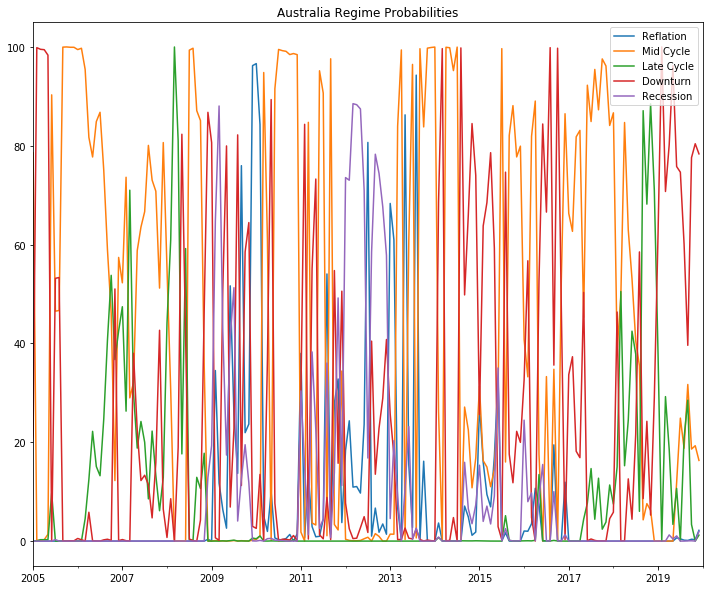

In [25]:
% matplotlib  inline


TotalProb.plot(figsize=(12,10))
plt.axis(['2005-01-01',EndDate,-5,105])
plt.title('Australia Regime Probabilities')